# Estimating grid cell fire probabailities

Authors: Jatan Buch (v1, 220207) || (v2, 220216)

## 1 - Packages

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import shap

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
data_dir= "../data/"
clim_df= pd.read_hdf('../data/clim_fire_freq_12km_data.h5')
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64) #sets all non-zero frequencies to 1
clim_df= clim_df[clim_df.reg_indx != 0].reset_index().drop(columns= ['index'])

## Data preprocessing

In [3]:
n_features= 36
start_month= 372
rseed= np.random.randint(1000)

fire_freq_train_ur_df= clim_df[clim_df.month < start_month].reset_index().drop(columns=['index'])
fire_freq_test_df= clim_df[clim_df.month >= start_month].reset_index().drop(columns=['index'])

tmp_freq_df= clim_df[clim_df.iloc[:, 0:n_features].columns] 
X_freq_df= pd.DataFrame({})
scaler= StandardScaler().fit(fire_freq_train_ur_df.iloc[:, 0:n_features])
X_freq_df[tmp_freq_df.columns]= scaler.transform(tmp_freq_df)

In [4]:
X_test_df= X_freq_df.iloc[-len(fire_freq_test_df):].reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', \
                                                                    'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])
X_test_df['reg_indx']= fire_freq_test_df.reg_indx
X_test_df['month']= fire_freq_test_df.month
y_test_arr= np.array(fire_freq_test_df.fire_freq)

X_train_tot= X_freq_df.iloc[0:len(fire_freq_train_ur_df)].reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', \
                                                                    'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])
X_train_tot['reg_indx']= fire_freq_train_ur_df.reg_indx
X_train_tot['month']= fire_freq_train_ur_df.month

X_test_tot= pd.concat([X_train_tot, X_test_df], sort= False).reset_index().drop(columns=['index'])
fire_freq_tot= pd.concat([fire_freq_train_ur_df, fire_freq_test_df], sort= False).reset_index().drop(columns=['index'])

## MDN grid scale frequency 

### Model loading

In [25]:
run_id= '02_26_22'
hp_df= pd.read_hdf('../sav_files/grid_freq_runs_%s'%run_id + '/grid_freq_hyperparams.h5')

In [26]:
hp_df

,Iteration,Batch size,Fire fraction,Epochs,Val Accuracy
0,1,2048,0.3,6,35.484475
1,1,2048,0.5,6,29.878368
2,1,8192,0.3,6,35.555660
3,1,8192,0.5,6,29.875345
4,2,2048,0.3,95,65.646241
5,2,2048,0.5,152,56.420342
6,2,8192,0.3,90,64.910768
7,2,8192,0.5,114,53.336486
8,3,2048,0.3,26,80.515938
9,3,2048,0.5,47,78.405310


In [19]:
it= 3 #hp_df.groupby('Iteration').get_group(2).groupby('Fire fraction').get_group(0.3)['Iteration'].to_numpy()[0]
bs= 8192
p_frac= 0.5
mdn_grid_zipd= tf.keras.models.load_model('../sav_files/grid_freq_runs_%s'%run_id + '/mdn_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d'%it, \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})

### Frequency prediction

In [8]:
def grid_freq_predict(X_test_dat, freq_test_df, n_regs, ml_model, start_month, final_month= 432, func_flag= 'zipd'):
    
    # Predicts the grid scale fire frequency for each L3 ecoregion
    
    n_regions= n_regs
    tot_months= final_month - start_month
    ml_freq_df= pd.DataFrame([])
    
    for r in tqdm(range(n_regions)):
        pred_freq= []
        pred_freq_sig= []
        freq_arr= []
        for m in np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64):
            X_arr= np.array(X_test_dat.groupby('reg_indx').get_group(r+1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']), dtype= np.float32)
            if func_flag == 'zipd':
                param_vec= ml_model.predict(x= tf.constant(X_arr))
                freq_samp= zipd_model(param_vec).sample(10000, seed= 99)
                pred_freq.append(tf.reduce_sum(tf.cast(tf.reduce_mean(freq_samp, axis= 0), tf.int64)).numpy())
                pred_freq_sig.append(np.sqrt(tf.reduce_sum(tf.pow(tf.cast(tf.math.reduce_std(freq_samp, axis= 0), tf.int64), 2)).numpy()).astype(np.int64))
                freq_arr.append(tf.cast(tf.reduce_mean(freq_samp, axis= 0), tf.int64).numpy())
            
            elif func_flag == 'logistic':
                reg_predictions= ml_model.predict(x= tf.constant(X_arr)).flatten()
                freq_arr.append([1 if p > 0.5 else 0 for p in reg_predictions])
                pred_freq.append(np.sum([1 if p > 0.5 else 0 for p in reg_predictions]))
        
        obs_freqs= [np.sum(freq_test_df.groupby('reg_indx').get_group(r+1).groupby('month').get_group(m).fire_freq) \
                                                                          for m in np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)]
        rescale_factor= (np.std(obs_freqs)/np.std(pred_freq))
        pred_freq_arr= [np.ceil(np.sum(freq_arr[m - start_month])*rescale_factor) for m in np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)]
        reg_indx_arr= np.ones(tot_months, dtype= np.int64)*(r+1)
        
        if func_flag == 'zipd':
            pred_high_2sig= np.ceil((np.array(pred_freq) + 2*np.array(pred_freq_sig))*rescale_factor)
            pred_low= np.array(pred_freq) - 2*np.array(pred_freq_sig)
            pred_low[pred_low < 0]= 0
            pred_low_2sig= np.floor(pred_low*rescale_factor)

            ml_freq_df= ml_freq_df.append(pd.DataFrame({'obs_freq': obs_freqs, 'pred_mean_freq': pred_freq_arr, 'pred_high_2sig': pred_high_2sig, 'pred_low_2sig': pred_low_2sig, \
                                                                                                                                  'reg_indx': reg_indx_arr}))
        if func_flag == 'logistic':
            ml_freq_df= ml_freq_df.append(pd.DataFrame({'obs_freq': obs_freqs, 'pred_mean_freq': pred_freq_arr, 'reg_indx': reg_indx_arr}))
        
    return ml_freq_df

In [27]:
def reg_pred_freq(X_test_dat, freq_test_df, nregs, start_month, func_flag, run_id, it, bs, p_frac):
    
    mdn_grid_zipd= tf.keras.models.load_model('../sav_files/grid_freq_runs_%s'%run_id + '/mdn_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d'%it, \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
    
    mdn_freq_df= grid_freq_predict(X_test_dat, freq_test_df, nregs, ml_model= mdn_grid_zipd, start_month= start_month, func_flag= func_flag)
    mdn_freq_df.to_hdf('../sav_files/mdn_mon_fire_freq_%s'%run_id + '_it_%d'%it + '_%s'%bs + '_%s.h5'%str(p_frac), key= 'df', mode= 'w')
    
    print('Saved monthly grid predictions for: mdn_mon_fire_freq_%s'%run_id + '_it_%d'%it + '_%s'%bs + '_%s.h5'%str(p_frac))

In [28]:
reg_pred_freq(X_test_dat= X_test_tot, freq_test_df= fire_freq_tot, nregs= 2, start_month= 0, func_flag= 'zipd', run_id= '02_26_22', it= 3, bs= 8192, p_frac= 0.3)

100%|██████████| 2/2 [22:34<00:00, 677.15s/it]


Saved monthly grid predictions for: mdn_mon_fire_freq_02_26_22_it_3_8192_0.3.h5


In [36]:
reg_pred_freq(X_test_dat= X_test_tot, freq_test_df= fire_freq_tot, nregs= 2, start_month= 0, func_flag= 'zipd', run_id= '02_26_22', it= 3, bs= 8192, p_frac= 0.5)

100%|██████████| 2/2 [20:31<00:00, 615.88s/it]

Saved monthly grid predictions for: mdn_mon_fire_freq_02_26_22_it_3_8192_0.5.h5


In [11]:
final_month= 432
tot_months= final_month #- start_month
n_regions= 18

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, final_month - 1, tot_months, dtype= np.int64)
year_arr= np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) #np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021])
yr_arr= np.arange(0, tot_months + 1, 12) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[10, 11, 12], [13, 14, 16]]

### Regional frequencies

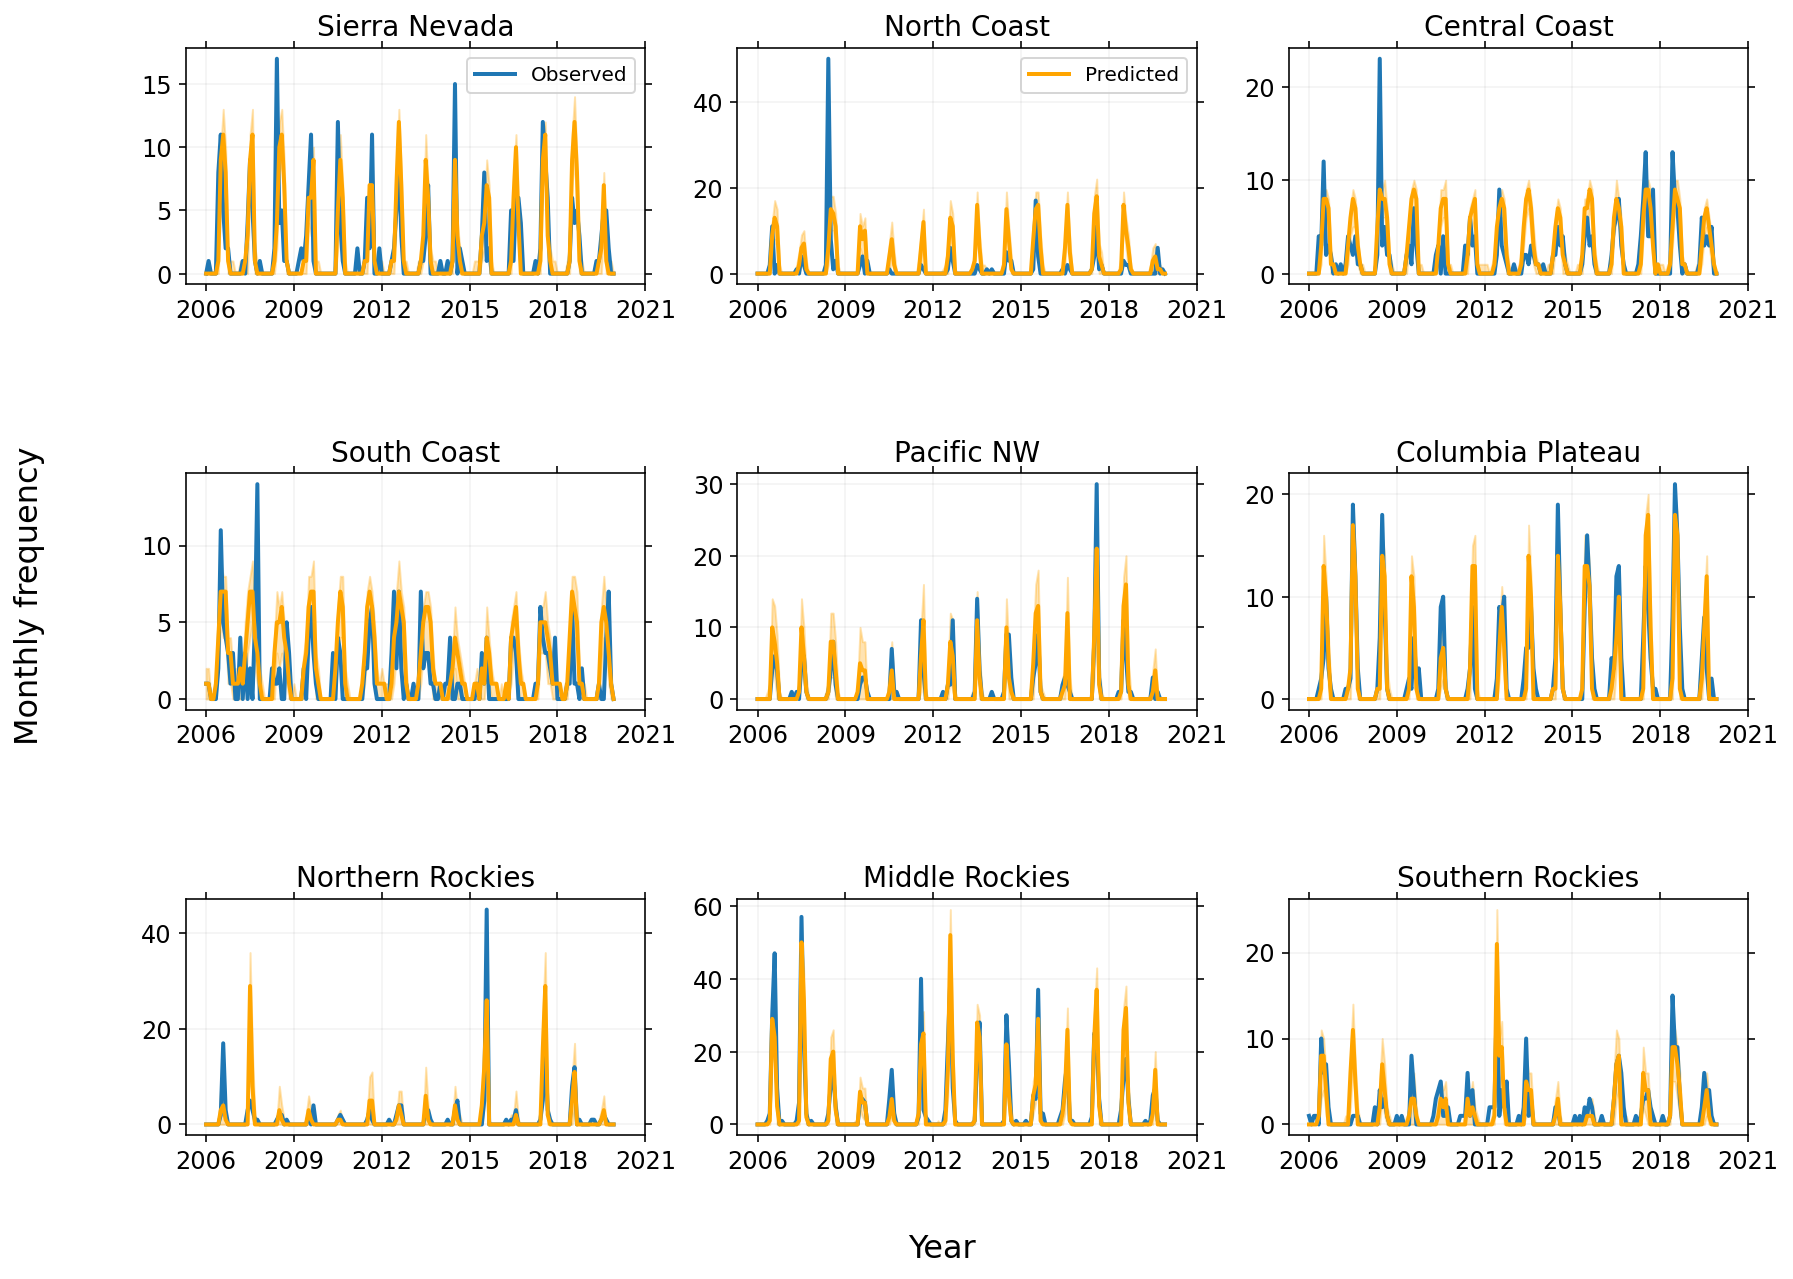

In [51]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['obs_freq'], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['obs_freq'], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'orange', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2006)*12 + start_month);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_fire_freq_1.pdf', bbox_inches='tight');

In [123]:
stats.pearsonr(mdn_freq_groups.get_group(4)['obs_freq'], mdn_freq_groups.get_group(4)['pred_mean_freq'])[0]

0.5586554552524383

In [124]:
stats.pearsonr(np.array([np.sum(mdn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)]), \
                                                np.array([np.sum(mdn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)]))[0]

0.7125281093735826

In [46]:
stats.pearsonr(dnn_freq_groups.get_group(14)['obs_freq'], dnn_freq_groups.get_group(14)['pred_mean_freq'])[0]

0.8492750608106875

In [121]:
np.array([np.sum(mdn_freq_groups.get_group(4)['obs_freq'].iloc[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)])

array([31, 28, 14, 16, 10, 16, 22, 18,  9,  9, 11, 25, 12, 13])

In [122]:
np.array([np.sum(mdn_freq_groups.get_group(4)['pred_mean_freq'].iloc[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)])

array([35., 35., 27., 28., 21., 29., 31., 30., 15., 15., 21., 25., 27.,
       21.])

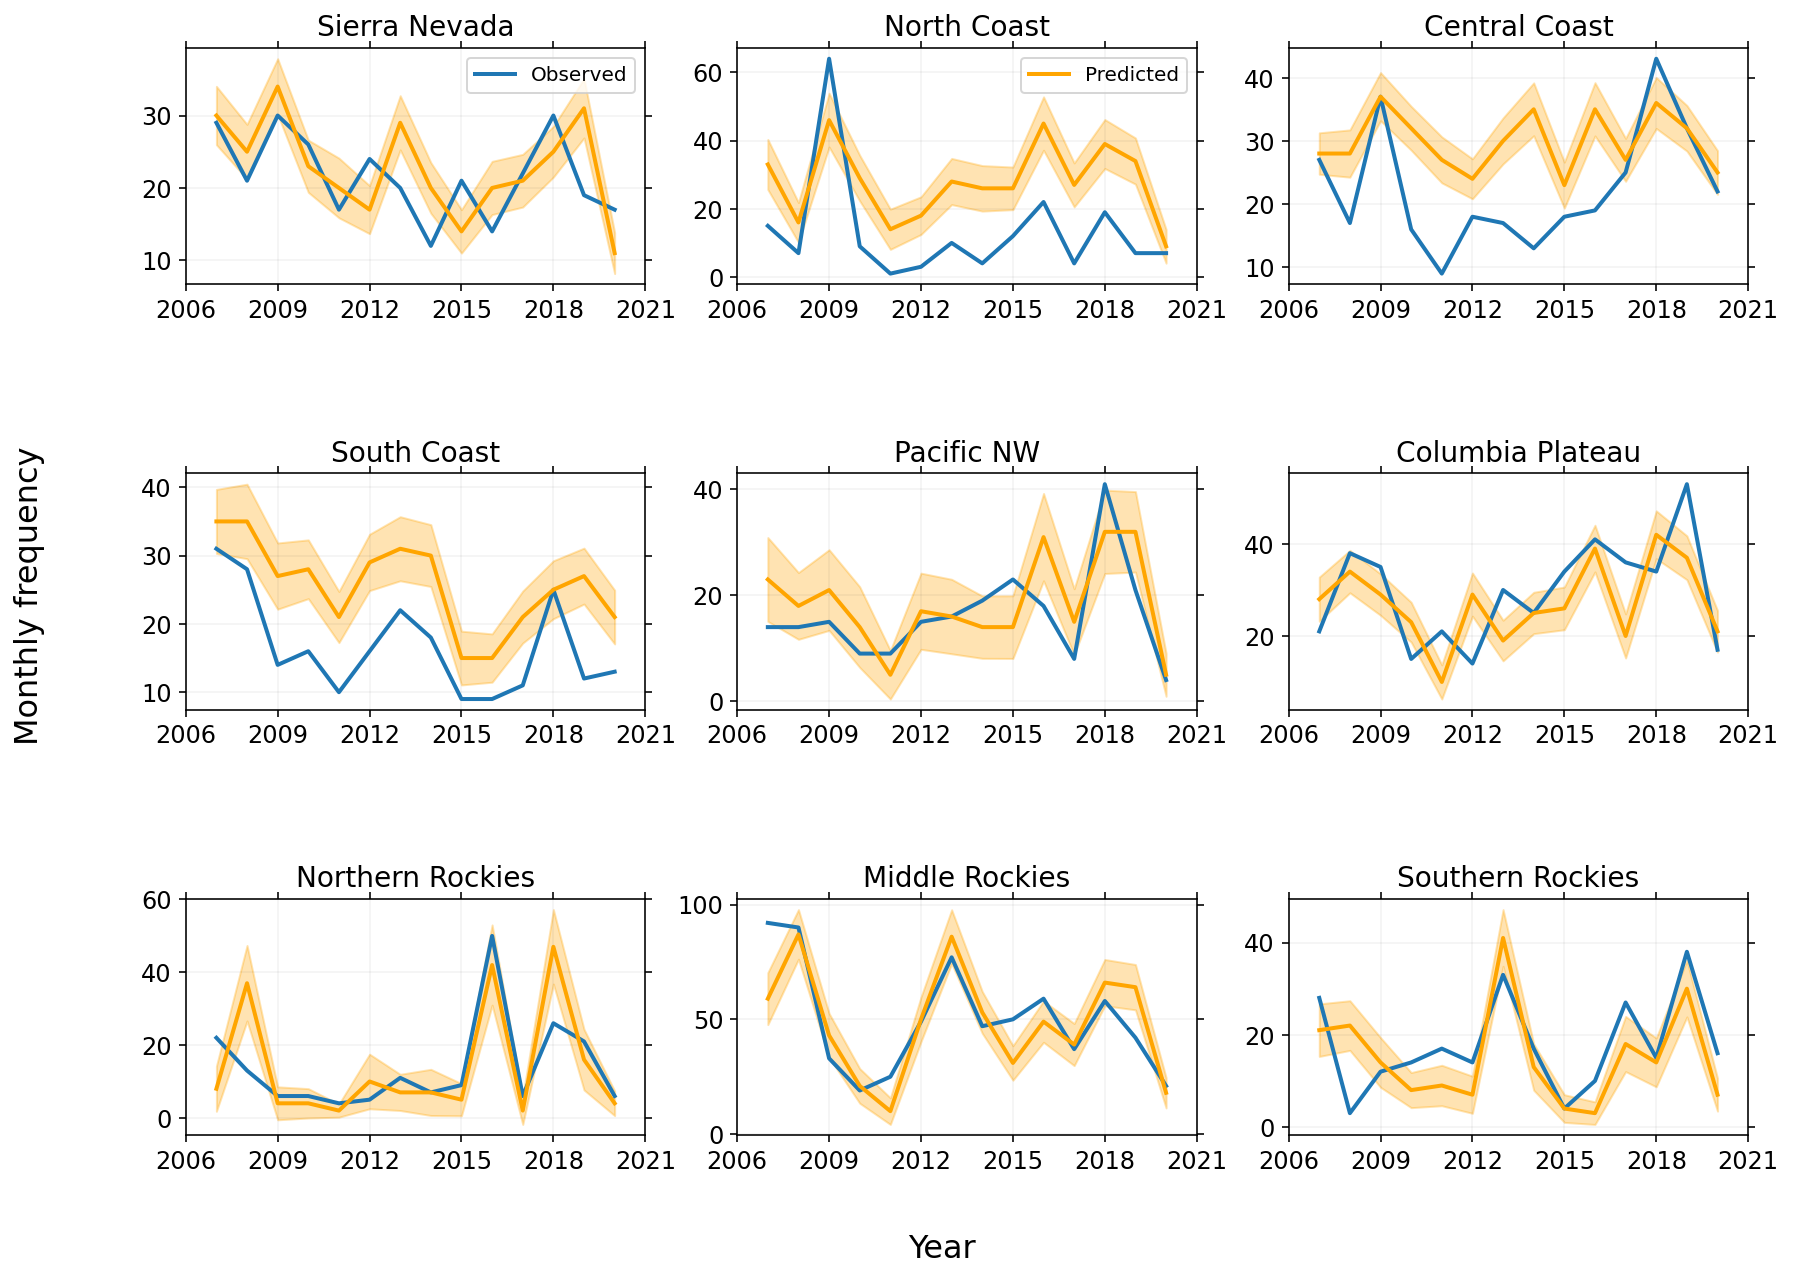

In [116]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        obs_freqs= np.array([np.sum(mdn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])
        pred_freqs= np.array([np.sum(mdn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])
        pred_std= np.asarray([np.sqrt(np.sum((((mdn_freq_groups.get_group(regindx)['pred_high_2sig'] - \
                    mdn_freq_groups.get_group(regindx)['pred_low_2sig'])/4)**2)[yr_arr[t]:yr_arr[t+1]])) for t in range(len(yr_arr) - 1)]) 
        if i+j == 0:
            ax[i, j].plot(yr_arr[1:], obs_freqs, lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(yr_arr[1:], obs_freqs, lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(yr_arr[1:], pred_freqs, color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(yr_arr[1:], pred_freqs, color= 'orange', lw= 2);
        ax[i, j].fill_between(yr_arr[1:], pred_freqs + 2*pred_std, pred_freqs - 2*pred_std, color= 'orange', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2006)*12);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_fire_freq_1.pdf', bbox_inches='tight');

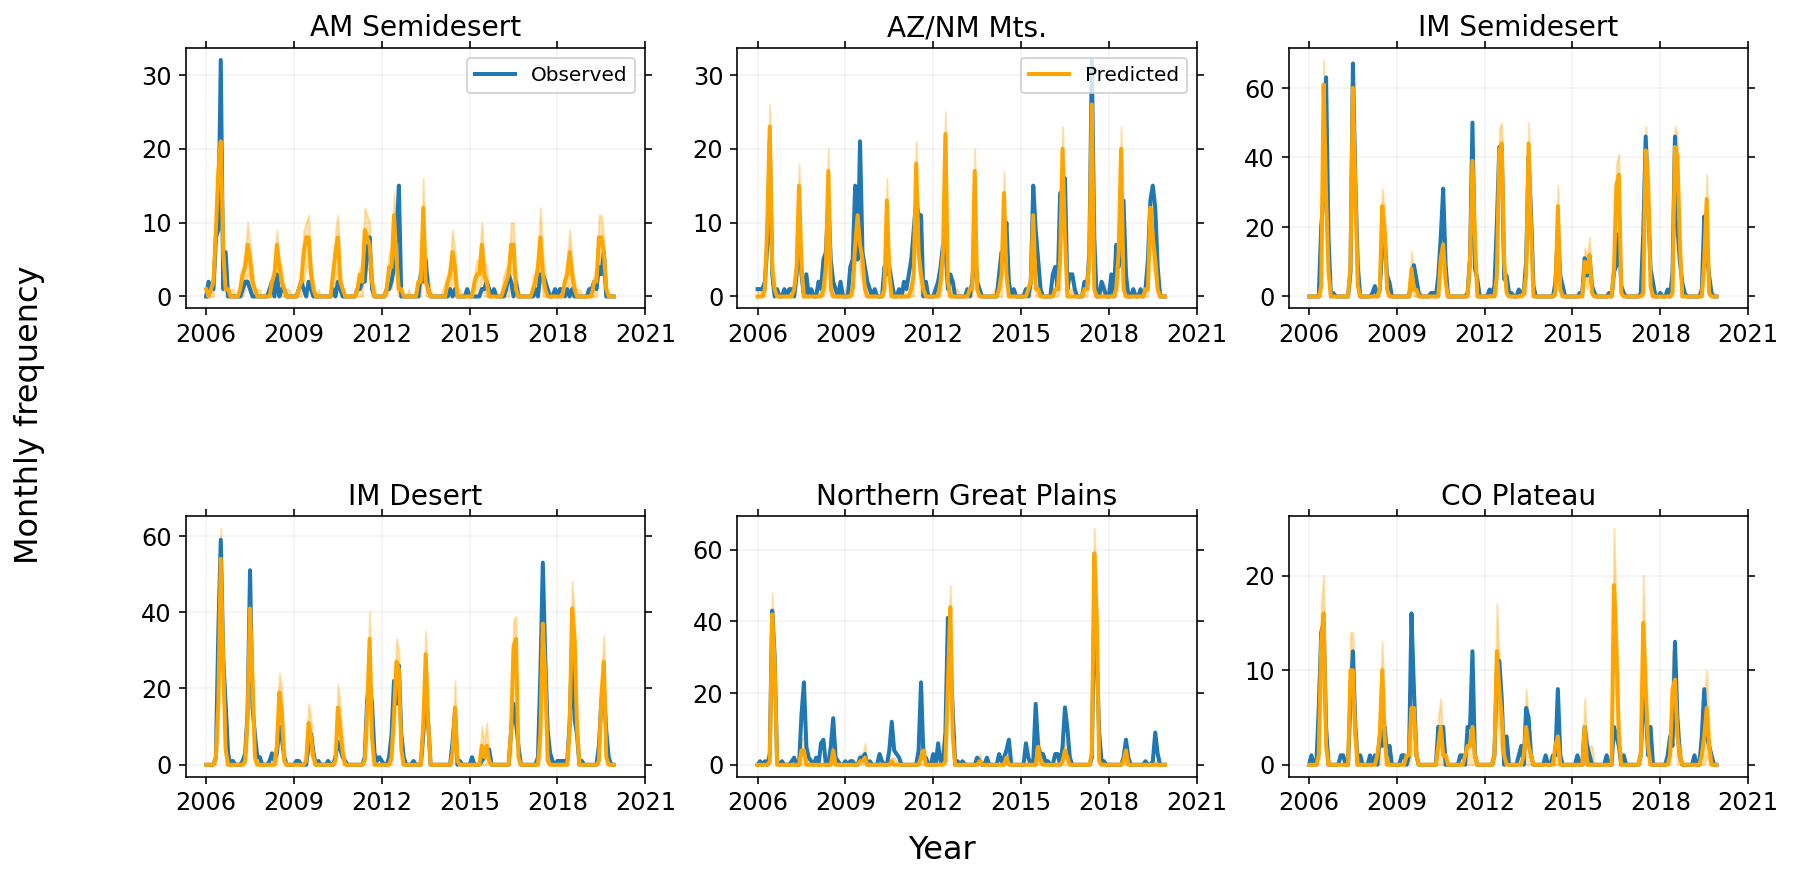

In [52]:
fig, ax= plt.subplots(2, 3, figsize=(14, 6.7))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['obs_freq'], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['obs_freq'], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'orange', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2006)*12 + start_month);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_fire_freq_2.pdf', bbox_inches='tight');

In [378]:
#mdn_freq_df.to_hdf('../sav_files/mdn_mon_freq_df.h5', key= 'df', mode= 'w')

In [398]:
[np.std(reg_freq_groups.get_group(r+1)['obs_freq'])/np.std(mdn_freq_groups.get_group(r+1)['pred_mean_freq']) for r in range(n_regions)]

[0.03366296893858744,
 0.07717101665303086,
 0.03204862928366784,
 0.058045248706160305,
 0.036996611420810316,
 0.06011370950582189,
 0.04981601776631776,
 0.04965923030794126,
 0.03821499690762673,
 0.02991582098456349,
 0.04736538426016781,
 0.056563337078187295,
 0.058785016070106035,
 0.05794992765798443,
 0.03630899153688874,
 0.02685424839172827,
 0.07717670578919737,
 0.021280455112061225]

### Sanity check

In [40]:
tmparr= np.random.choice(np.nonzero(freq_arr[6])[0], (np.sum(freq_arr[6])*(np.std(reg_freq_groups.get_group(1)['obs_freq'])/np.std(pred_freq))).astype(int))

In [41]:
X_test_df.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']).index.to_numpy()[tmparr]

array([3746133, 3741808, 3750194, 3741511, 3748828, 3749649, 3742959])

In [37]:
mdn_freq_df= pd.read_hdf('../sav_files/mdn_mon_fire_freq_02_26_22_it_3_8192_0.5.h5')
mdn_freq_groups= mdn_freq_df.groupby('reg_indx')

In [41]:
run_id= '02_25_22'
it= 1
bs= 8192
p_frac= 0.3
dnn_grid_mod= tf.keras.models.load_model('../sav_files/grid_freq_runs_%s'%run_id + '/dnn_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d'%it)

In [46]:
pred_freq= []
freq_arr= []
        
for m in tqdm(np.linspace(372, 431, 60, dtype= np.int64)):
    X_arr= np.array(X_test_tot.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']), dtype= np.float32)
    reg_predictions= dnn_grid_mod.predict(x= tf.constant(X_arr)).flatten()
    freq_arr.append([1 if p > 0.5 else 0 for p in reg_predictions])
    pred_freq.append(np.sum([1 if p > 0.5 else 0 for p in reg_predictions]))
        
obs_freqs= [np.sum(fire_freq_tot.groupby('reg_indx').get_group(1).groupby('month').get_group(m).fire_freq) \
                                                                          for m in np.linspace(372, 431, 60, dtype= np.int64)]
rescale_factor= (np.std(obs_freqs)/np.std(pred_freq))
    #pred_freq_arr= [np.ceil(np.sum(freq_arr[m - start_month])*rescale_factor) for m in np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)]

100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


In [60]:
yr_arr= np.arange(0, 61, 12)

In [68]:
np.concatenate([np.floor(np.array(pred_freq[yr_arr[t]:yr_arr[t+1]])*(np.std(obs_freqs[yr_arr[t]:yr_arr[t+1]])/np.std(pred_freq[yr_arr[t]:yr_arr[t+1]]))) \
                                                                                                                for t in range(len(yr_arr) - 1)])

array([ 0.,  0.,  0.,  0.,  0.,  4.,  4.,  5.,  4.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  6.,  6.,  4.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  4., 10., 10.,  7.,  3.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  2.,  5.,  5.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  4.,  5.,  2.,  1.,  0.,  0.])

In [66]:
pred_freq_arr= [np.ceil(np.sum(freq_arr[m - start_month])*rescale_factor) for m in np.linspace(372, 431, 60, dtype= np.int64)]

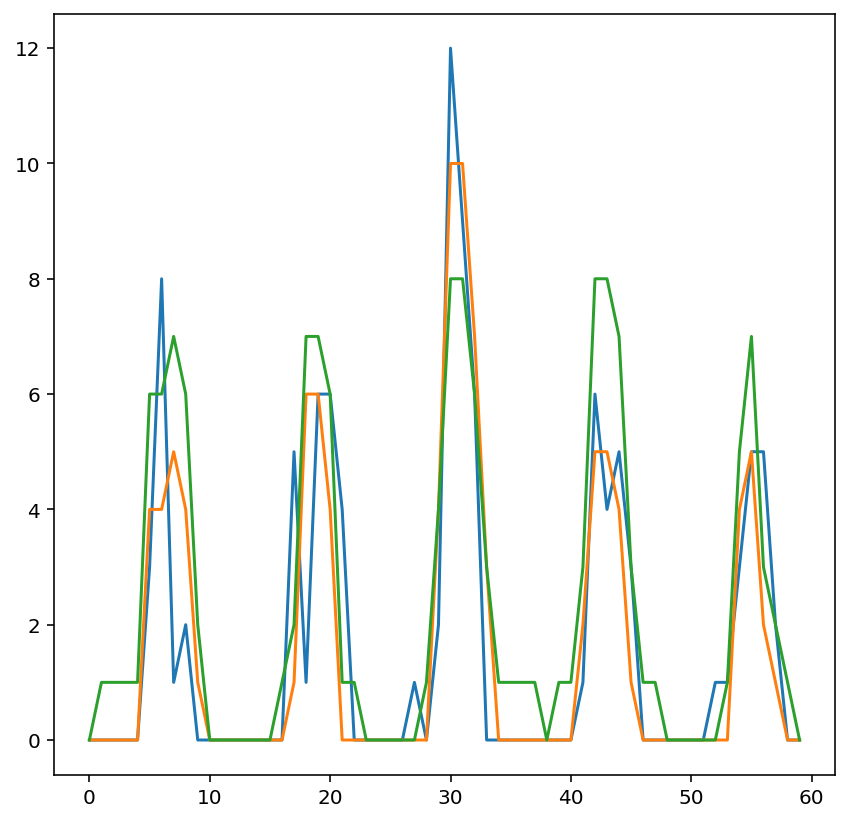

In [69]:
fig, ax= plt.subplots(1, 1, figsize=(7, 7))
regindx= 1

plt.plot(np.linspace(0, 59, 60), obs_freqs);
plt.plot(np.linspace(0, 59, 60), np.concatenate([np.floor(np.array(pred_freq[yr_arr[t]:yr_arr[t+1]])*(np.std(obs_freqs[yr_arr[t]:yr_arr[t+1]])/np.std(pred_freq[yr_arr[t]:yr_arr[t+1]]))) \
                                                                                                                for t in range(len(yr_arr) - 1)]));
plt.plot(np.linspace(0, 59, 60), pred_freq_arr);
#plt.fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'orange', alpha= 0.3)

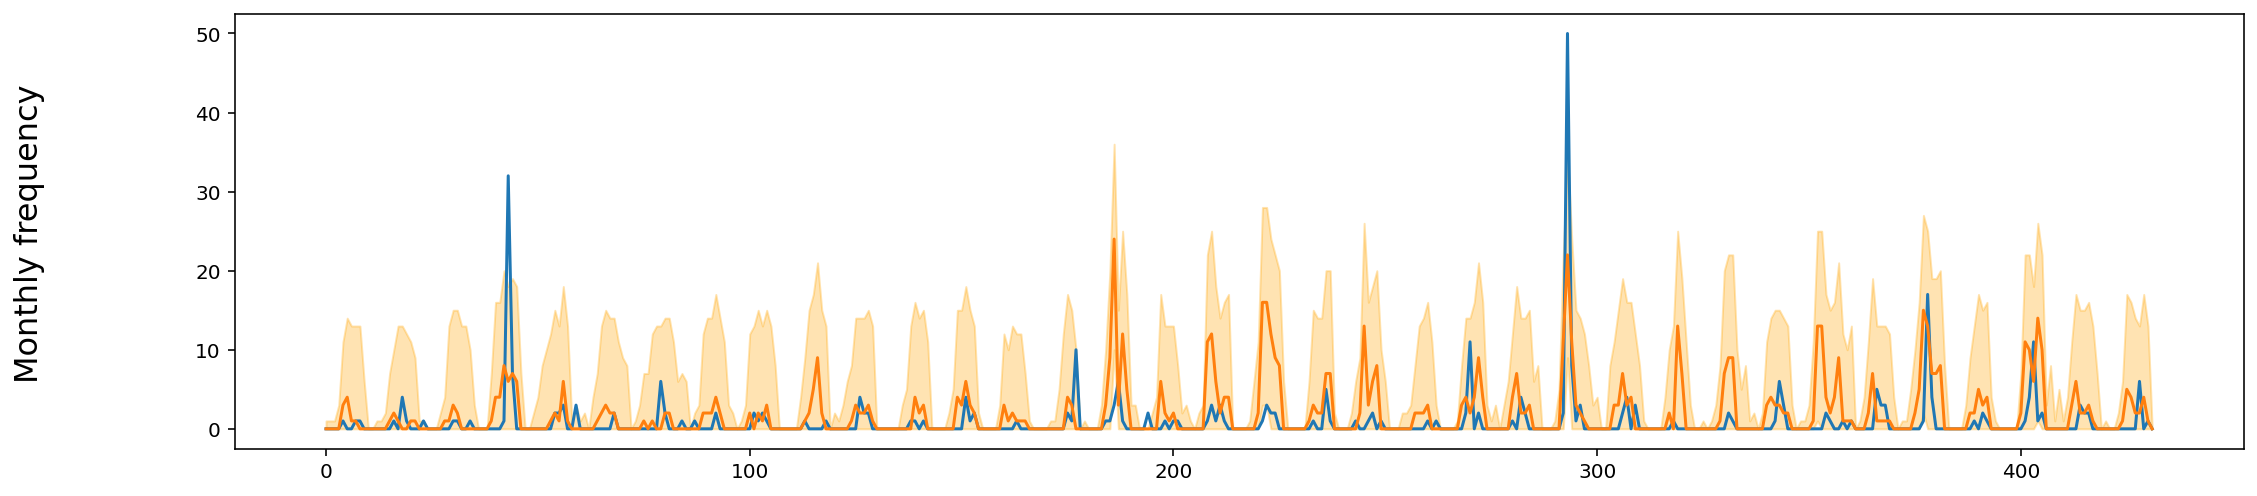

In [38]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 2

plt.plot(month_arr, mdn_freq_groups.get_group(regindx)['obs_freq'])
plt.plot(month_arr, mdn_freq_groups.get_group(regindx)['pred_mean_freq']);
plt.fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'orange', alpha= 0.3)

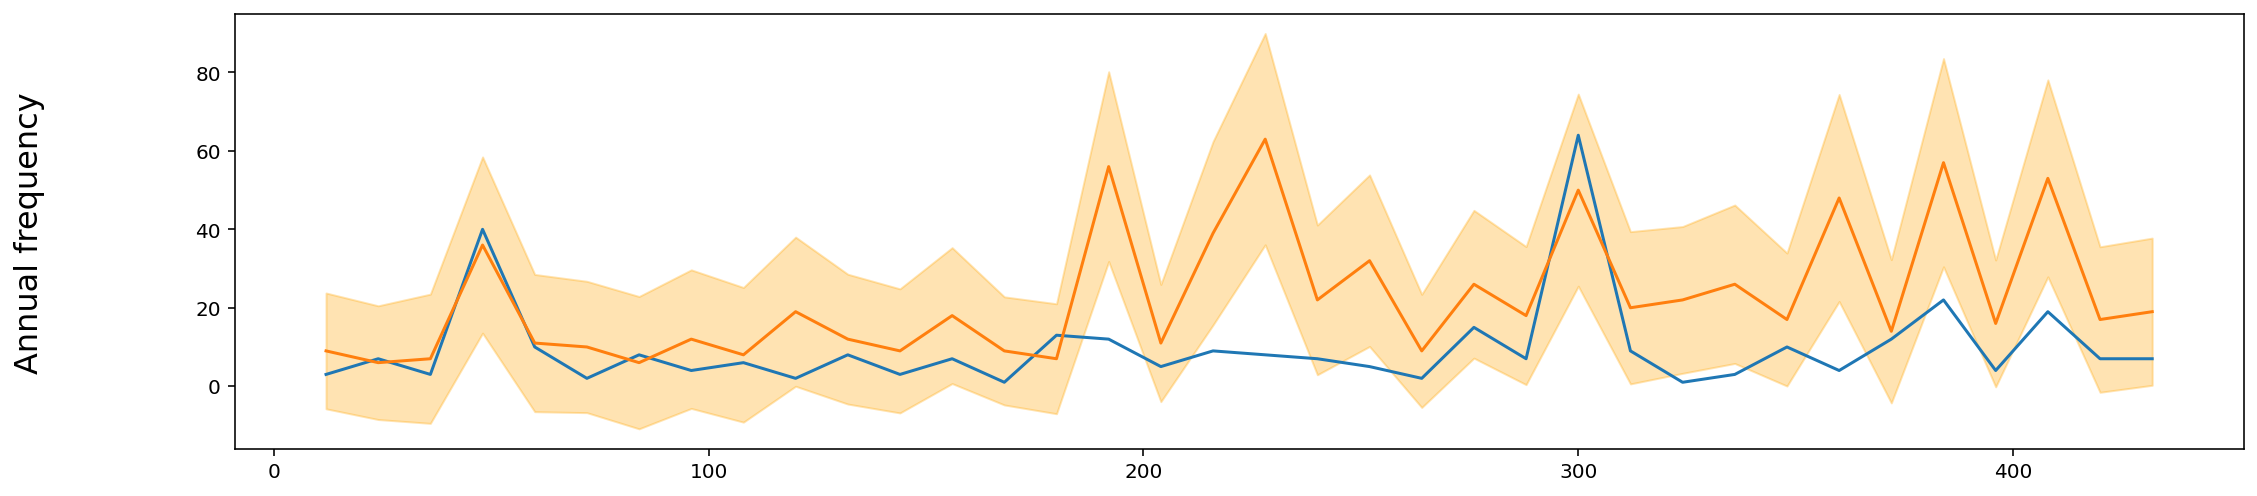

In [39]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Annual frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 2

pred_std= np.asarray([np.sqrt(np.sum((((mdn_freq_groups.get_group(regindx)['pred_high_2sig'] - \
                    mdn_freq_groups.get_group(regindx)['pred_low_2sig'])/4)**2)[yr_arr[t]:yr_arr[t+1]])) for t in range(len(yr_arr) - 1)])  
pred_freq= np.array([np.sum(mdn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])

plt.plot(yr_arr[1:], np.array([np.sum(mdn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)]));
plt.plot(yr_arr[1:], pred_freq);
plt.fill_between(yr_arr[1:], pred_freq + 2*pred_std, pred_freq - 2*pred_std, color= 'orange', alpha= 0.3)